# 2. Training eines MLPs auf den Spielzeugdaten
Der Code aus dem Beispielnotebook muss zunächst an das Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalem statt zehndimensionalem Output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator

In [2]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    # return 1.0/(1.0+np.exp(-z))
    return np.tanh(z)

In [3]:
# Create labels (class 1 in quadrants 1 & 3, class 0 in quadrants 2 & 4)
def create_labels(X):
    y = np.zeros(X.shape[0])
    for i, (x1, x2) in enumerate(X):
        if np.sign(x1) == np.sign(x2):
            y[i] = 1
    return y

In [4]:
# Fixed input neuron weights
w1 = np.array([0, 1])  # horizontal split
w2 = np.array([1, 0])  # vertical split

Vorgehensweise:

1. Setzen Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatritzen auf Korrektheit.


In [5]:
mbs = 10
epochs = 150
lr = 0.03

sizes = [2, 2, 2, 1]
sizes_names = ['input', 'hidden1', 'hidden2', 'output']
num_layers = len(sizes)

weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
biases = [np.random.randn(y, 1) for y in sizes[1:]]
for i, x in enumerate(weights):
    print(f"From {sizes_names[i]} → {sizes_names[i + 1]}:")
    print(x.shape)

From input → hidden1:
(2, 2)
From hidden1 → hidden2:
(2, 2)
From hidden2 → output:
(1, 2)


2. Der Beispielcode verwendet One-Hot-Coding für die Labels, in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern, dass ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Output kleiner als 0.5 ist und bei Klasse 1 größer als 0.5. Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf uns speichern Sie diesen in einem zusätzlichen Array ab.

In [6]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

In [7]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""

    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    mse = []

    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        y = y2[i] # Klasse 0 oder Klasse 1

        # Vorwärtslauf
        ypred = feedforward(x).flatten()[0]

         # Calculate MSE for each class
        mse.append(np.mean((ypred - y) ** 2))

        # Output < 0  → Klasse 0
        # Output ≥ 0 → Klasse 1
        pred_class = 1 if ypred > 0 else 0

        if pred_class == y:
            correct += 1

    return correct, np.array(mse)

3. Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar. Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung zuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher mehrere Male und vergeleichen Sie die Ergebnisse.

In [8]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    # return sigmoid(z)*(1-sigmoid(z))
    return 1.0 - np.tanh(z)**2

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

In [9]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)

    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

In [10]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()

        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)

        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]

    return (weights, biases)

In [11]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten

    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    mse = np.zeros(epochs)
    for j in range(epochs):

        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]

        # Zerlege den permutierten Datensatz in Minibatches
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)

        # Gib Performance aus
        evaluated = evaluate(x2, y2)
        acc_val[j] = evaluated[0]
        mse[j] = np.mean(evaluated[1])
        # print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))

    return acc_val, mse

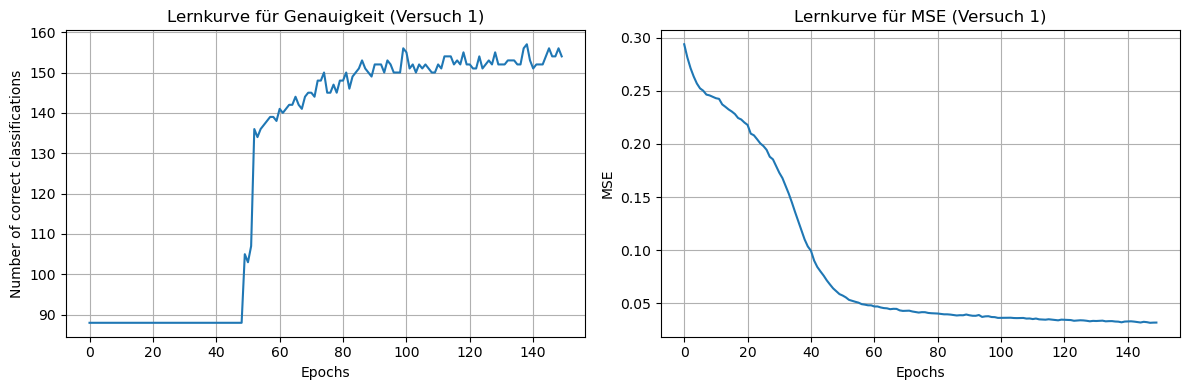

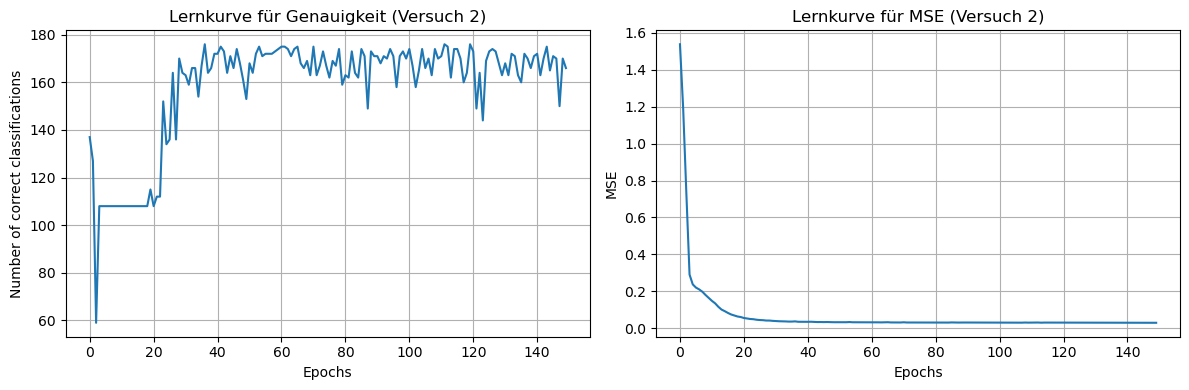

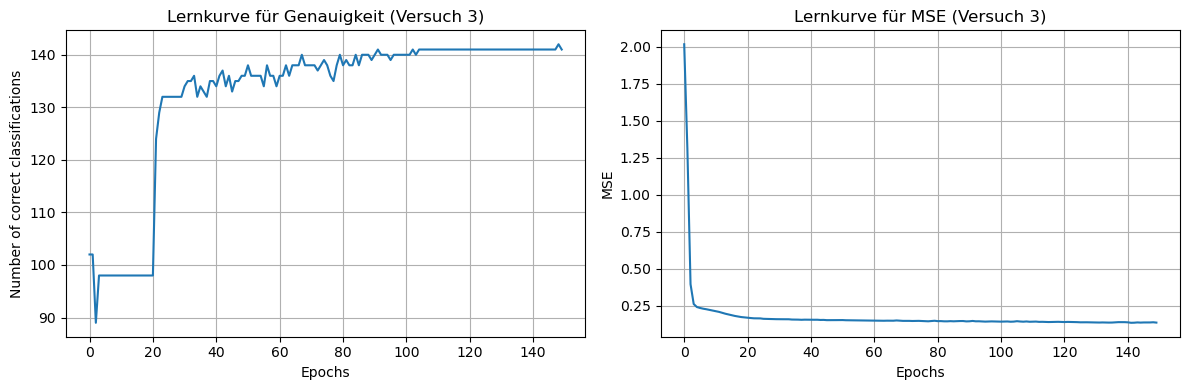

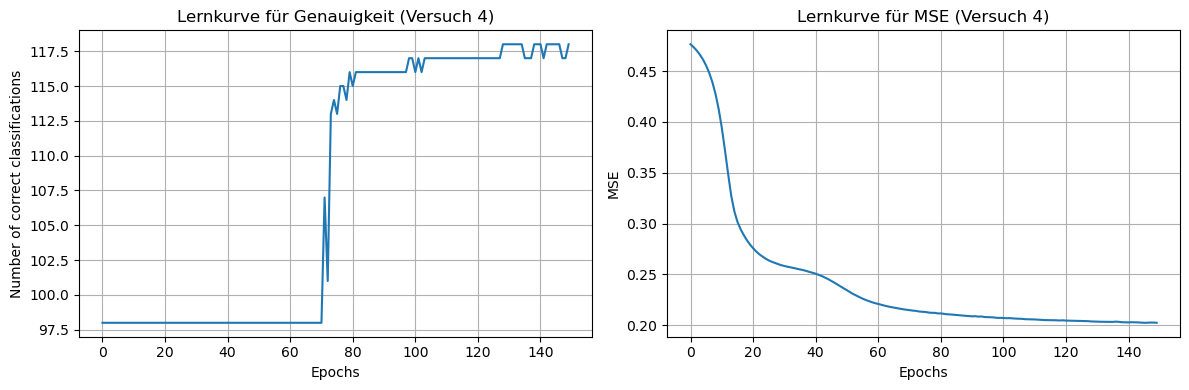

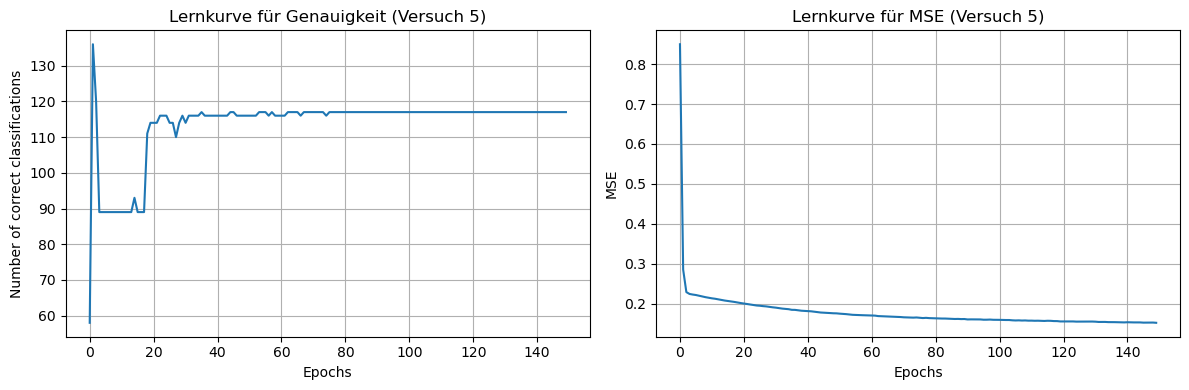

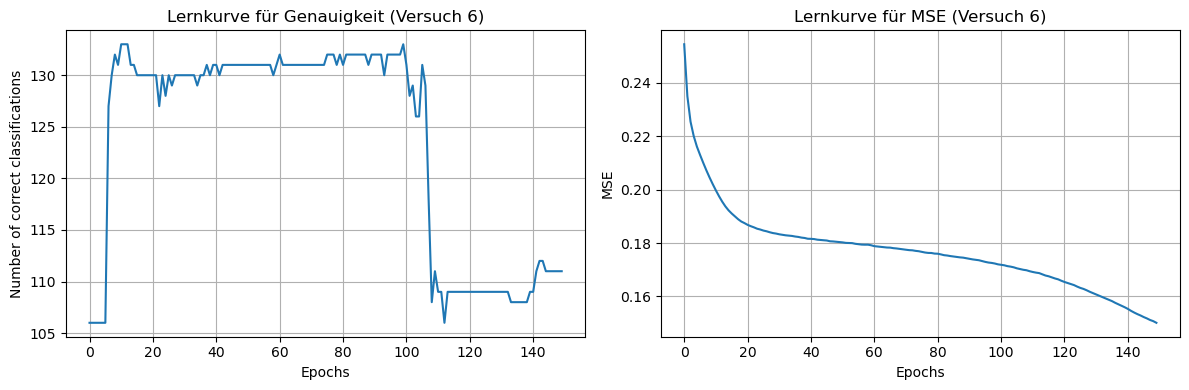

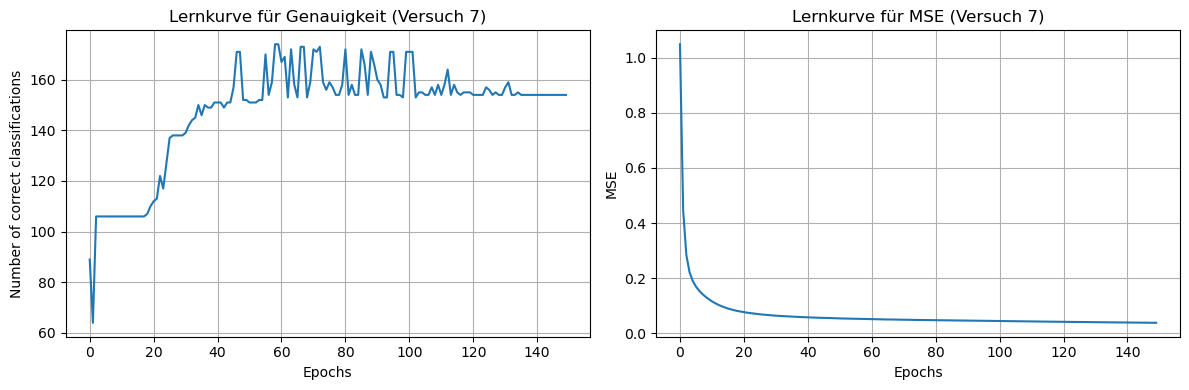

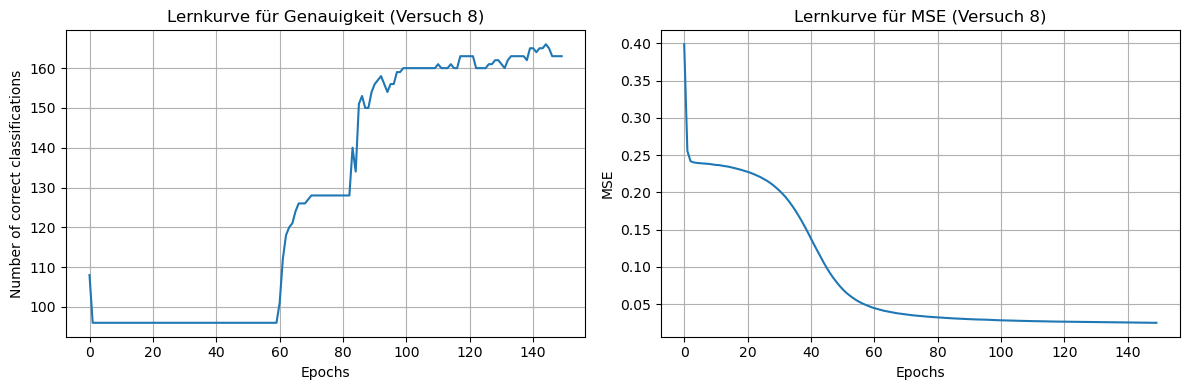

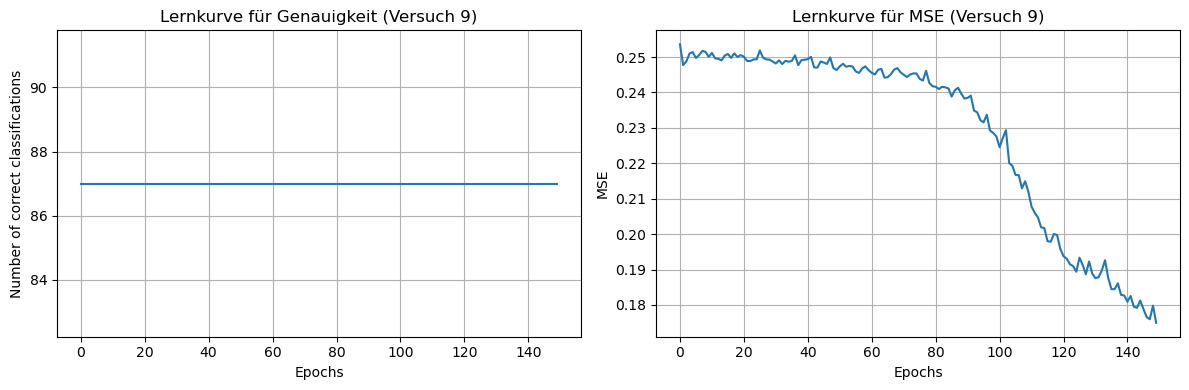

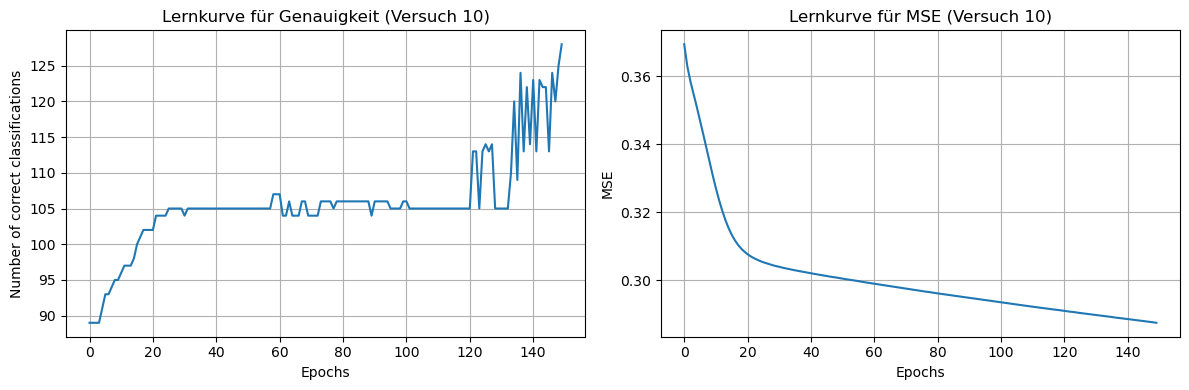

In [12]:
repeat_experiment = 10
all_trains = np.zeros(repeat_experiment, dtype=tuple)
all_weights = []  # Store weights for each experiment
all_biases = []   # Store biases for each experiment

for i in range(repeat_experiment):
    # ----------------- Prepare random seeded data ------------------
    # Generate training data
    np.random.seed(11 + i)
    X_train = np.random.uniform(low=-6, high=6, size=(200, 2))
    # Generate test data
    np.random.seed(22 + i)
    X_test = np.random.uniform(low=-6, high=6, size=(200, 2))
    y_train = create_labels(X_train)

    all_trains[i] = (X_train, y_train)

    y_test = create_labels(X_test)
    x0 = np.column_stack([
        sigmoid(w1[0] * X_train[:, 0] + w1[1] * X_train[:, 1]),
        sigmoid(w2[0] * X_train[:, 0] + w2[1] * X_train[:, 1])
    ])
    x1 = np.column_stack([
        sigmoid(w1[0] * X_test[:, 0] + w1[1] * X_test[:, 1]),
        sigmoid(w2[0] * X_test[:, 0] + w2[1] * X_test[:, 1])
    ])
    y0 = y_train
    y1 = y_test
    x2 = x1
    y2 = y1

    # ----------------- Initialize weights for this experiment ------------------
    sizes = [2, 2, 2, 1]
    weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    biases = [np.random.randn(y, 1) for y in sizes[1:]]

    # ----------------- Train MLP ------------------
    acc_val, mse = SGD(x0, y0, epochs, mbs, lr, x2, y2)

    # ----------------- Save weights after training ------------------
    all_weights.append([w.copy() for w in weights])
    all_biases.append([b.copy() for b in biases])

    # ----------------- Plot learning curves ------------------
    x_plt = np.arange(0, epochs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(x_plt, acc_val)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Number of correct classifications')
    axes[0].grid()
    axes[0].set_title(f'Lernkurve für Genauigkeit (Versuch {i + 1})')

    axes[1].plot(x_plt, mse)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MSE')
    axes[1].grid()
    axes[1].set_title(f'Lernkurve für MSE (Versuch {i + 1})')

    plt.tight_layout()
    plt.show()

4. Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

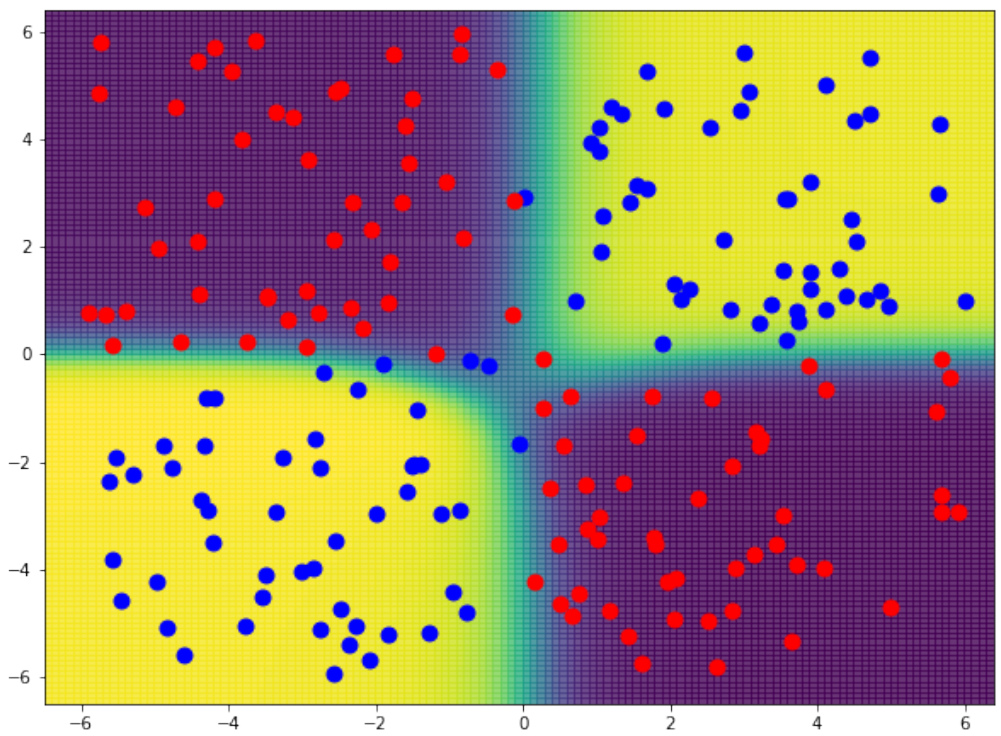

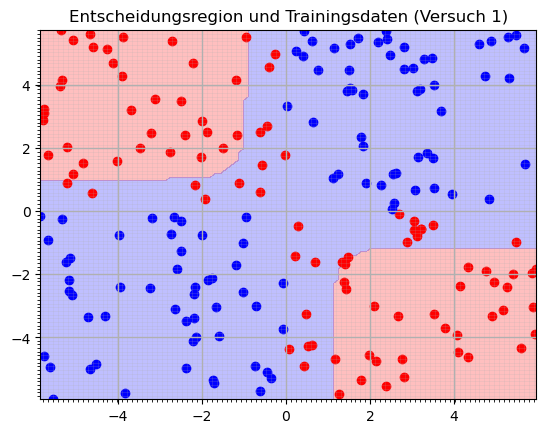

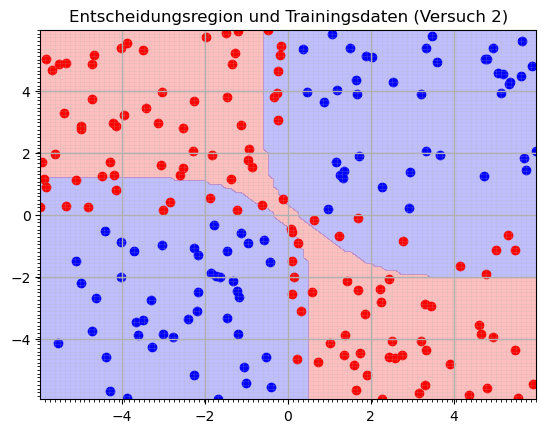

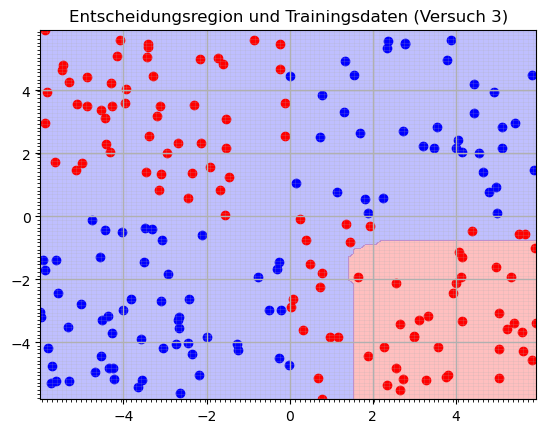

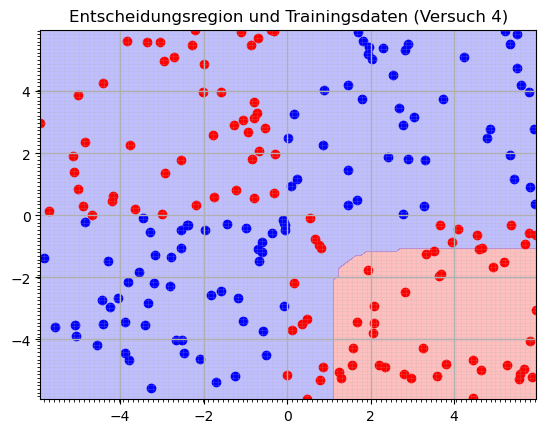

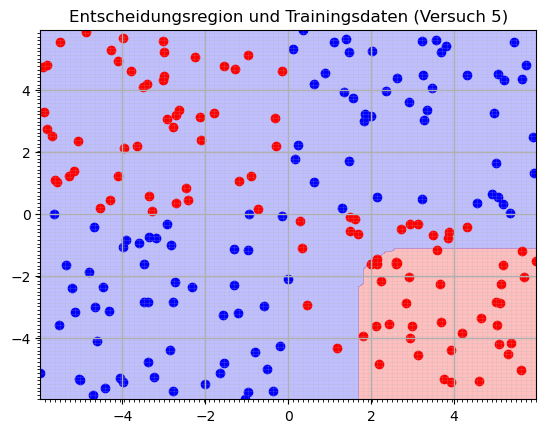

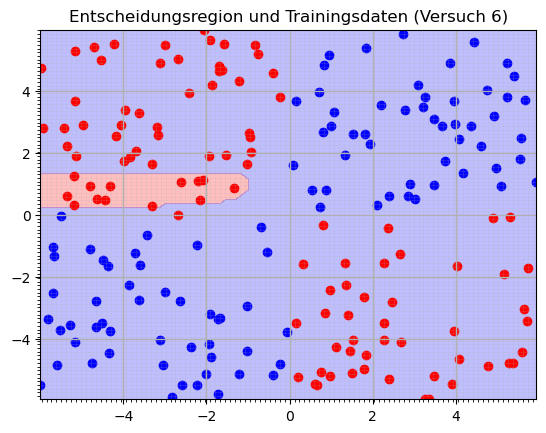

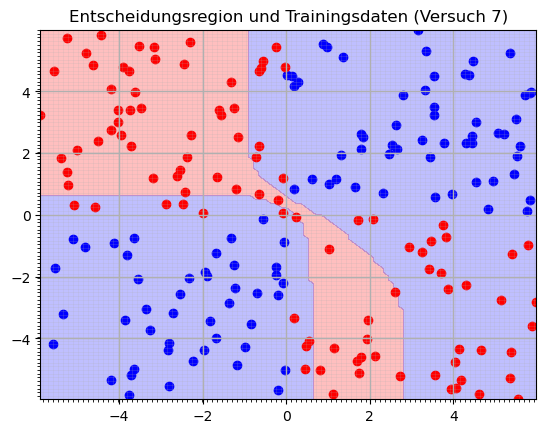

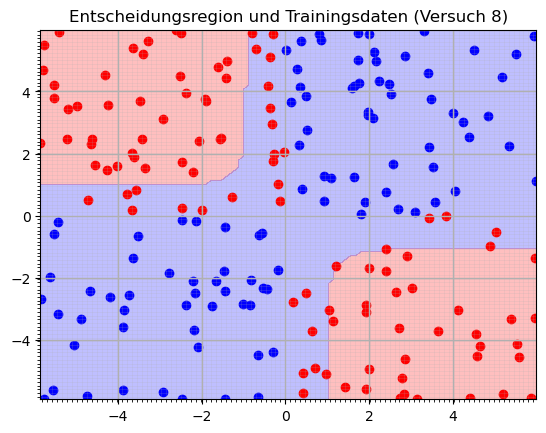

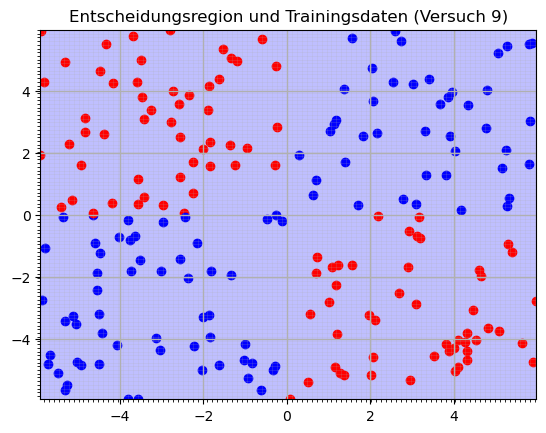

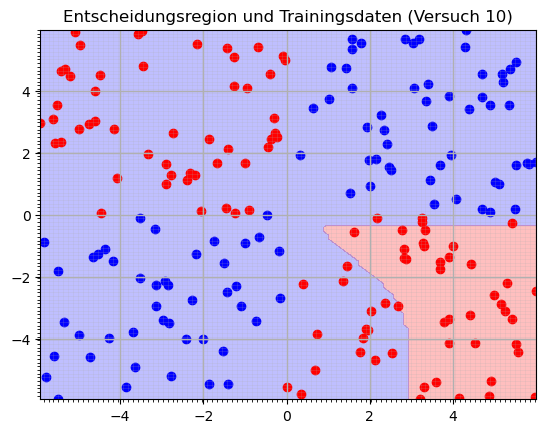

In [13]:
for k, (X_train, y_train) in enumerate(all_trains):
    min_x1 = np.min(X_train[:,0])
    max_x1 = np.max(X_train[:,0])
    min_x2 = np.min(X_train[:,1])
    max_x2 = np.max(X_train[:,1])

    fig, ax = plt.subplots()

    # --- Use weights from this specific experiment ---
    weights = all_weights[k]
    biases = all_biases[k]

    # --- Entscheidungsregion -----------------

    xx, yy = np.meshgrid(
        np.linspace(min_x1, max_x1, 100),
        np.linspace(min_x2, max_x2, 100)
    )

    Z = np.zeros(xx.shape)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x1 = xx[i, j]
            x2 = yy[i, j]

            # dieselbe Vorverarbeitung wie beim Training:
            z1 = sigmoid(w1[0] * x1 + w1[1] * x2)  # = sigmoid(x2)
            z2 = sigmoid(w2[0] * x1 + w2[1] * x2)  # = sigmoid(x1)

            a0 = np.array([[z1],
                           [z2]])   # Input fürs MLP

            ypred = feedforward(a0).flatten()[0] # Entscheidungsfunktion
            Z[i, j] = ypred

    Z_cls = (Z > 0).astype(int)
    ax.contourf(xx, yy, Z_cls,
                levels=[-0.5, 0.5, 1.5],
                colors=["red", "blue"],
                alpha=0.25)

    # --- Trainingsdatenpunkte -----------------

    for x, y in zip(X_train, y_train):
        if y == 0:
            ax.scatter(x[0], x[1], color="red")
        else:
            ax.scatter(x[0], x[1], color="blue")

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.xaxis.set_minor_locator(MultipleLocator((max_x1 - min_x1) / 100))
    ax.yaxis.set_minor_locator(MultipleLocator((max_x2 - min_x2) / 100))

    ax.grid(which="major", linewidth=1.0)
    ax.grid(which="minor", linewidth=0.4, alpha=0.3)

    plt.title(f'Entscheidungsregion und Trainingsdaten (Versuch {k + 1})')
    plt.show()

## 3 Beispiele aus der Vorlesung

Trainiere und vergleiche 3 verschiedene Architekturen:
1. **[2, 2, 1]** - Eine versteckte Schicht mit 2 Neuronen
2. **[2, 3, 1]** - Eine versteckte Schicht mit 3 Neuronen
3. **[2, 3, 2, 1]** - Zwei versteckte Schichten mit 3 und 2 Neuronen

In [14]:
# 3 Architekturen aus der Vorlesung
architectures = [
    [2, 2, 1],      # 1 hidden layer, 2 neurons
    [2, 3, 1],      # 1 hidden layer, 3 neurons  
    [2, 3, 2, 1]    # 2 hidden layers, 3 and 2 neurons
]

# Prepare data (same for all architectures)
np.random.seed(42)
X_train = np.random.uniform(low=-6, high=6, size=(200, 2))
X_test = np.random.uniform(low=-6, high=6, size=(200, 2))
y_train = create_labels(X_train)
y_test = create_labels(X_test)

x0 = np.column_stack([
    sigmoid(w1[0] * X_train[:, 0] + w1[1] * X_train[:, 1]),
    sigmoid(w2[0] * X_train[:, 0] + w2[1] * X_train[:, 1])
])
x2 = np.column_stack([
    sigmoid(w1[0] * X_test[:, 0] + w1[1] * X_test[:, 1]),
    sigmoid(w2[0] * X_test[:, 0] + w2[1] * X_test[:, 1])
])
y0 = y_train
y2 = y_test

# Train each architecture with 10 different seeds
results = []
num_seeds = 10

for arch_idx, arch in enumerate(architectures):
    print(f"\n{'='*60}")
    print(f"Architektur {arch_idx + 1}: {arch}")
    print('='*60)
    
    arch_results = []
    
    # Try 10 different random seeds
    for seed in range(num_seeds):
        # Initialize weights and biases for this architecture
        np.random.seed(42 + seed)
        sizes = arch
        num_layers = len(sizes)
        weights = [np.random.randn(y, x) * np.sqrt(1.0/x) for x, y in zip(sizes[:-1], sizes[1:])]
        biases = [np.zeros((y, 1)) for y in sizes[1:]]
        
        # Train
        acc_val, mse = SGD(x0, y0, epochs, mbs, lr, x2, y2)
        
        final_acc = acc_val[-1]
        final_mse = mse[-1]
        
        # Store results
        arch_results.append({
            'seed': seed,
            'weights': [w.copy() for w in weights],
            'biases': [b.copy() for b in biases],
            'acc_val': acc_val,
            'mse': mse,
            'final_acc': final_acc,
            'final_mse': final_mse
        })
        
        print(f"  Seed {seed:2d}: Acc = {final_acc:5.1f}/{len(y2)} ({100*final_acc/len(y2):5.1f}%), MSE = {final_mse:.4f}")
    
    # Find best result
    best_result = max(arch_results, key=lambda x: x['final_acc'])
    avg_acc = np.mean([r['final_acc'] for r in arch_results])
    std_acc = np.std([r['final_acc'] for r in arch_results])
    
    print(f"\n  → Beste:  {best_result['final_acc']:.1f}/{len(y2)} ({100*best_result['final_acc']/len(y2):.1f}%)")
    print(f"  → Durchschnitt: {avg_acc:.1f} ± {std_acc:.1f} ({100*avg_acc/len(y2):.1f}% ± {100*std_acc/len(y2):.1f}%)")
    
    # Store summary
    results.append({
        'architecture': arch,
        'all_results': arch_results,
        'best_result': best_result,
        'avg_acc': avg_acc,
        'std_acc': std_acc
    })

print(f"\n{'='*60}")
print("Zusammenfassung:")
print('='*60)
for idx, result in enumerate(results):
    arch = result['architecture']
    best_acc = result['best_result']['final_acc']
    avg_acc = result['avg_acc']
    std_acc = result['std_acc']
    print(f"Architektur {idx+1} {arch}:")
    print(f"  Beste: {100*best_acc/len(y2):.1f}%, Durchschnitt: {100*avg_acc/len(y2):.1f}% ± {100*std_acc/len(y2):.1f}%")


Architektur 1: [2, 2, 1]
  Seed  0: Acc = 105.0/200 ( 52.5%), MSE = 0.1490
  Seed  1: Acc = 167.0/200 ( 83.5%), MSE = 0.0243
  Seed  2: Acc = 169.0/200 ( 84.5%), MSE = 0.0195
  Seed  3: Acc = 167.0/200 ( 83.5%), MSE = 0.0242
  Seed  4: Acc = 105.0/200 ( 52.5%), MSE = 0.1437
  Seed  5: Acc = 170.0/200 ( 85.0%), MSE = 0.0213
  Seed  6: Acc = 139.0/200 ( 69.5%), MSE = 0.1382
  Seed  7: Acc = 167.0/200 ( 83.5%), MSE = 0.0281
  Seed  8: Acc = 142.0/200 ( 71.0%), MSE = 0.1337
  Seed  9: Acc = 160.0/200 ( 80.0%), MSE = 0.0281

  → Beste:  170.0/200 (85.0%)
  → Durchschnitt: 149.1 ± 24.4 (74.5% ± 12.2%)

Architektur 2: [2, 3, 1]
  Seed  0: Acc = 170.0/200 ( 85.0%), MSE = 0.0271
  Seed  1: Acc = 169.0/200 ( 84.5%), MSE = 0.0219
  Seed  2: Acc = 173.0/200 ( 86.5%), MSE = 0.0204
  Seed  3: Acc = 122.0/200 ( 61.0%), MSE = 0.0313
  Seed  4: Acc = 168.0/200 ( 84.0%), MSE = 0.0243
  Seed  5: Acc = 174.0/200 ( 87.0%), MSE = 0.0211
  Seed  6: Acc = 168.0/200 ( 84.0%), MSE = 0.0229
  Seed  7: Acc = 166

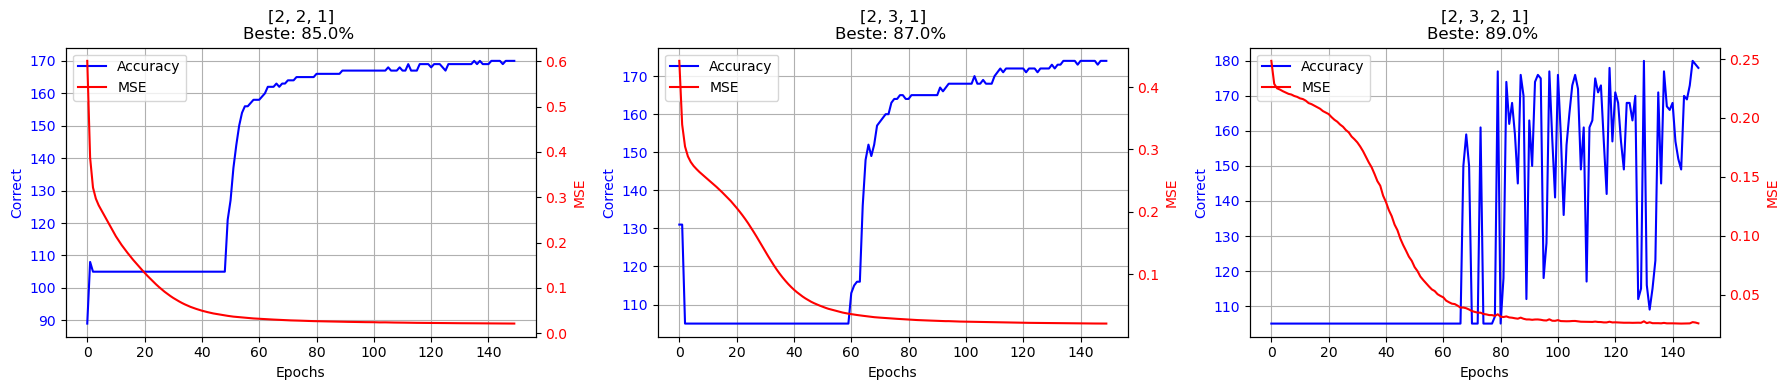

In [15]:
# Plot learning curves for the BEST run of each architecture
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for idx, result in enumerate(results):
    arch = result['architecture']
    best = result['best_result']
    acc_val = best['acc_val']
    mse = best['mse']
    
    # Plot accuracy
    ax = axes[idx]
    ax2 = ax.twinx()
    
    x_plt = np.arange(0, epochs)
    line1 = ax.plot(x_plt, acc_val, 'b-', label='Accuracy')
    line2 = ax2.plot(x_plt, mse, 'r-', label='MSE')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Correct', color='b')
    ax2.set_ylabel('MSE', color='r')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid()
    
    avg_acc = result['avg_acc']
    std_acc = result['std_acc']
    ax.set_title(f'{arch}\nBeste: {100*best["final_acc"]/len(y2):.1f}% ')
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

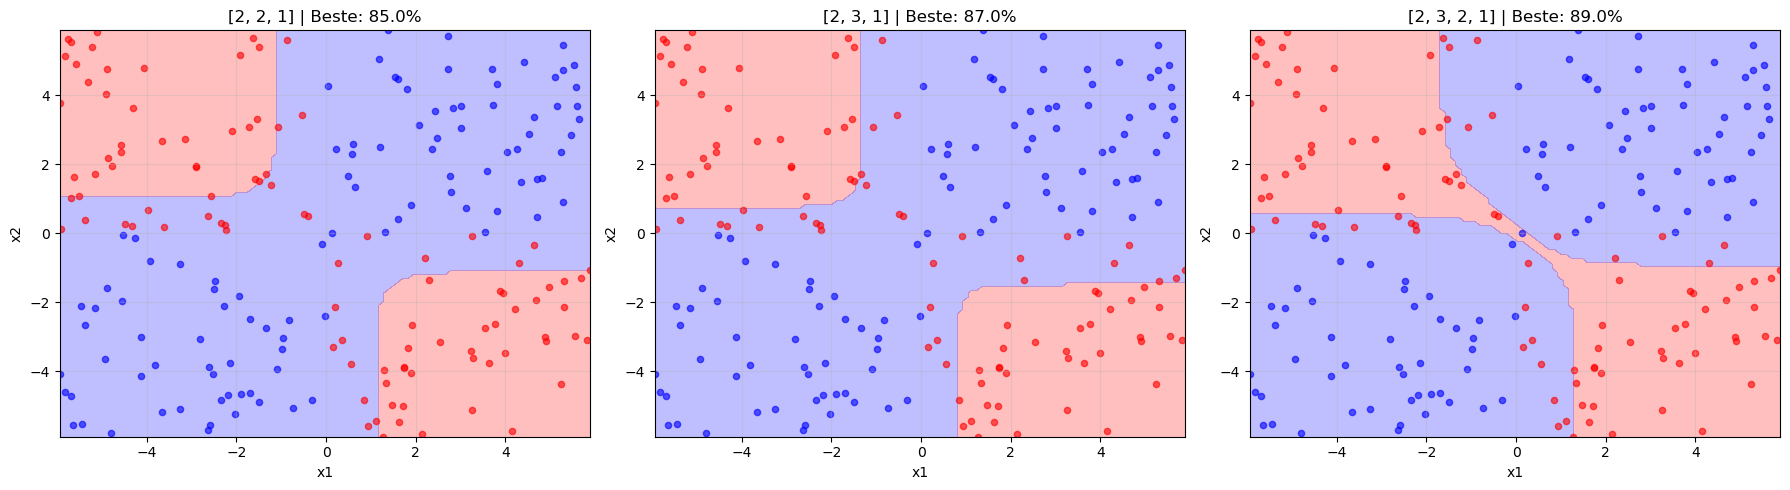

In [16]:
# Plot decision boundaries for the BEST run of each architecture
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

min_x1 = np.min(X_train[:,0])
max_x1 = np.max(X_train[:,0])
min_x2 = np.min(X_train[:,1])
max_x2 = np.max(X_train[:,1])

xx, yy = np.meshgrid(
    np.linspace(min_x1, max_x1, 100),
    np.linspace(min_x2, max_x2, 100)
)

for idx, result in enumerate(results):
    arch = result['architecture']
    best = result['best_result']
    
    # Restore weights and biases for the best result
    weights = best['weights']
    biases = best['biases']
    num_layers = len(arch)
    
    # Compute decision boundary
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x1 = xx[i, j]
            x2 = yy[i, j]
            
            z1 = sigmoid(w1[0] * x1 + w1[1] * x2)
            z2 = sigmoid(w2[0] * x1 + w2[1] * x2)
            
            a0 = np.array([[z1], [z2]])
            ypred = feedforward(a0).flatten()[0]
            Z[i, j] = ypred
    
    Z_cls = (Z > 0).astype(int)
    
    ax = axes[idx]
    ax.contourf(xx, yy, Z_cls,
                levels=[-0.5, 0.5, 1.5],
                colors=["red", "blue"],
                alpha=0.25)
    
    # Plot training data
    for x, y in zip(X_train, y_train):
        if y == 0:
            ax.scatter(x[0], x[1], color="red", s=20, alpha=0.6)
        else:
            ax.scatter(x[0], x[1], color="blue", s=20, alpha=0.6)
    
    ax.set_title(f'{arch} | Beste: {100*best["final_acc"]/len(y2):.1f}%')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.tight_layout()
plt.show()